In [43]:
#@title ***Importing required librarys***

import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

In [44]:
#@title ***Loading the dataset***

data = pd.read_csv("/kaggle/input/chatgpt-sentiment-analysis/file.csv")
data = data.drop([data.columns[0]], axis=1)
data.values[:5].tolist()

[['ChatGPT: Optimizing Language Models for Dialogue https://t.co/K9rKRygYyn @OpenAI',
  'neutral'],
 ['Try talking with ChatGPT, our new AI system which is optimized for dialogue. Your feedback will help us improve it. https://t.co/sHDm57g3Kr',
  'good'],
 ['ChatGPT: Optimizing Language Models for Dialogue https://t.co/GLEbMoKN6w #AI #MachineLearning #DataScience #ArtificialIntelligence\\n\\nTrending AI/ML Article Identified &amp; Digested via Granola; a Machine-Driven RSS Bot by Ramsey Elbasheer https://t.co/RprmAXUp34',
  'neutral'],
 ['THRILLED to share that ChatGPT, our new model optimized for dialog, is now public, free, and accessible to everyone. https://t.co/dyvtHecYbd https://t.co/DdhzhqhCBX https://t.co/l8qTLure71',
  'good'],
 ['As of 2 minutes ago, @OpenAI released their new ChatGPT. \\n\\nAnd you can use it right now 👇 https://t.co/VyPGPNw988 https://t.co/cSn5h6h1M1',
  'bad']]

# Drop duplicated values

In [45]:
print("Duplicated values: " , data.duplicated().sum())

data.drop_duplicates(inplace=True)
data = data.dropna(axis=0)
print(data.info())

Duplicated values:  1671
<class 'pandas.core.frame.DataFrame'>
Int64Index: 217623 entries, 0 to 219293
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   tweets  217623 non-null  object
 1   labels  217623 non-null  object
dtypes: object(2)
memory usage: 5.0+ MB
None


# balance data

In [46]:
data["labels"].value_counts()

bad        106695
good        55754
neutral     55174
Name: labels, dtype: int64

In [47]:
class_0 = data[data["labels"] == "neutral"]
class_1 = data[data["labels"] == "good"]
class_neg = data[data["labels"] == "bad"]
class_neg  = class_neg.iloc[:70000]
data = pd.concat([class_neg , class_0 , class_1])

data.head()

,tweets,labels
4,"As of 2 minutes ago, @OpenAI released their ne...",bad
6,"As of 2 minutes ago, @OpenAI released their ne...",bad
10,GOD DAMN IT @OpenAI STOP ANNOUNCING THINGS I A...,bad
17,#ai Models are set to become the search engine...,bad
39,Google is done.\n\nCompare the quality of thes...,bad


In [48]:
data["labels"].value_counts()

bad        70000
good       55754
neutral    55174
Name: labels, dtype: int64

# cleaning dataset

In [49]:
#@title ***Cleaning the dataset***
#!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/
import nltk
from nltk.corpus import wordnet as wn
from nltk.stem import WordNetLemmatizer,PorterStemmer

nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))
st = PorterStemmer()
lem = WordNetLemmatizer()

def is_alpha(word):
    for part in word.split('-'):
        if not part.isalpha():
            return False
    
    return True

def clean_dataset(text):
    text = re.sub(r'http\S+', '', text) # removing links
    text = re.sub(r'\\n', ' ', text) # removing \\n
    text = re.sub(r"\s*#\S+", "", text) # removing hash tags
    text = re.sub(r"\s*@\S+", "", text) # removing @
    text = text.lower()
    words = [word for word in word_tokenize(text) if is_alpha(word)]
    #words = [st.stem(word) for word in words]
    words = [lem.lemmatize(word) for word in words]
    
    # text = " ".join([word for word in text.split(" ") if is_alpha(word)])
    # text = re.sub(r'[^a-zA-Z\s]', '', text, re.I|re.A) 
    words = [w for w in words if not w in stop_words]
    text = " ".join(words)
    
    return text.strip()

data.insert(len(data.columns)-1, "cleaned_tweets", data['tweets'].apply(clean_dataset))
data.head()

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,tweets,cleaned_tweets,labels
4,"As of 2 minutes ago, @OpenAI released their ne...",minute ago released new chatgpt use right,bad
6,"As of 2 minutes ago, @OpenAI released their ne...",minute ago released new chatgpt use right,bad
10,GOD DAMN IT @OpenAI STOP ANNOUNCING THINGS I A...,god damn stop announcing thing busy,bad
17,#ai Models are set to become the search engine...,model set become search engine future atm stil...,bad
39,Google is done.\n\nCompare the quality of thes...,google done compare quality response chatgpt,bad


# converting dataset in numerical form

In [50]:
from numpy.core import numeric
#@title ***Converting text to numerical form***

import math
import collections

def convert_text_to_numerical(text):
    num_words = 7000
    tokenizer = Tokenizer(num_words=num_words)
    tokenizer.fit_on_texts(text)
    sequences = tokenizer.texts_to_sequences(text)
 
    #maxlen = max(45, math.ceil(np.average([len(seq) for seq in sequences])))
    maxlen = 140
    
 
    pad_seqs = pad_sequences(sequences, maxlen=maxlen)
    pad_seqs_todrop = []
    for i, p in enumerate(pad_seqs):
        if sum(p) == sum(sorted(p, reverse=True)[0:2]):
            pad_seqs_todrop.append(i)

    return pad_seqs, pad_seqs_todrop, tokenizer, num_words, maxlen

data = data.reset_index()
numeric_tweets, rows_todrop, tokenizer, num_words, maxlen = convert_text_to_numerical(data['cleaned_tweets'])
data.insert(len(data.columns)-1, "numeric_tweets", numeric_tweets.tolist())
data.head()

,index,tweets,cleaned_tweets,numeric_tweets,labels
0,4,"As of 2 minutes ago, @OpenAI released their ne...",minute ago released new chatgpt use right,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",bad
1,6,"As of 2 minutes ago, @OpenAI released their ne...",minute ago released new chatgpt use right,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",bad
2,10,GOD DAMN IT @OpenAI STOP ANNOUNCING THINGS I A...,god damn stop announcing thing busy,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",bad
3,17,#ai Models are set to become the search engine...,model set become search engine future atm stil...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",bad
4,39,Google is done.\n\nCompare the quality of thes...,google done compare quality response chatgpt,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",bad


In [51]:
#@title ***Encoding output labels***

label_encoder = LabelEncoder()
data.insert(len(data.columns), "encoded_labels", label_encoder.fit_transform(data['labels']))
print(label_encoder.classes_)
data.head()

['bad' 'good' 'neutral']


,index,tweets,cleaned_tweets,numeric_tweets,labels,encoded_labels
0,4,"As of 2 minutes ago, @OpenAI released their ne...",minute ago released new chatgpt use right,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",bad,0
1,6,"As of 2 minutes ago, @OpenAI released their ne...",minute ago released new chatgpt use right,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",bad,0
2,10,GOD DAMN IT @OpenAI STOP ANNOUNCING THINGS I A...,god damn stop announcing thing busy,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",bad,0
3,17,#ai Models are set to become the search engine...,model set become search engine future atm stil...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",bad,0
4,39,Google is done.\n\nCompare the quality of thes...,google done compare quality response chatgpt,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",bad,0


In [52]:
final_data = data.drop(rows_todrop, inplace=False)
print(len(data), len(final_data))
final_data.head()

180928 167641


,index,tweets,cleaned_tweets,numeric_tweets,labels,encoded_labels
0,4,"As of 2 minutes ago, @OpenAI released their ne...",minute ago released new chatgpt use right,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",bad,0
1,6,"As of 2 minutes ago, @OpenAI released their ne...",minute ago released new chatgpt use right,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",bad,0
2,10,GOD DAMN IT @OpenAI STOP ANNOUNCING THINGS I A...,god damn stop announcing thing busy,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",bad,0
3,17,#ai Models are set to become the search engine...,model set become search engine future atm stil...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",bad,0
4,39,Google is done.\n\nCompare the quality of thes...,google done compare quality response chatgpt,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",bad,0


# Splitting Data: taining 80% and 20% for testing

In [53]:
#@title ***Splitting the dataset into training and testing sets***
inputs = final_data[['tweets', 'cleaned_tweets', 'numeric_tweets']]
outputs = final_data[['labels', 'encoded_labels']]

in_train, in_test, out_train, out_test = train_test_split(inputs, outputs, test_size=0.2, shuffle=True, random_state=42)

X_train = in_train['numeric_tweets']
X_test = in_test['numeric_tweets'] 
y_train = out_train['encoded_labels']
y_test = out_test['encoded_labels']

# Saving training and testing data into csv files

In [54]:
#training_df = pd.concat([in_train, out_train], axis=1)
#training_df.to_csv('training_data.csv', encoding='utf-8', index=False)
#testing_df = pd.concat([in_test, out_test], axis=1)
#testing_df.to_csv('testing_data.csv', encoding='utf-8', index=False)

In [55]:
X_train = np.asarray(X_train.tolist())
X_train = X_train.astype(np.int32)
X_test = np.asarray(X_test.tolist()).astype(np.int32)
y_train = np.asarray(y_train.tolist()).astype(np.int32)
y_test = np.asarray(y_test.tolist()).astype(np.int32)
type(X_train)

numpy.ndarray

In [56]:
X_train

array([[   0,    0,    0, ...,  126,  235,  663],
       [   0,    0,    0, ..., 1799,  122,  607],
       [   0,    0,    0, ..., 1072, 4671,   48],
       ...,
       [   0,    0,    0, ..., 1659,  498,  498],
       [   0,    0,    0, ..., 2175,  138, 2226],
       [   0,    0,    0, ..., 2761, 5594,  936]], dtype=int32)

# Cnn training

In [57]:
#@title ***Building the CNN model***
from keras.callbacks import EarlyStopping
model1 = Sequential()
model1.add(Embedding(input_dim=num_words,output_dim=128, input_length=maxlen , trainable = True))

model1.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
model1.add(MaxPooling1D(pool_size=2))
model1.add(Flatten())
model1.add(Dense(64, activation='relu'))
model1.add(Dense(3, activation='softmax'))

model1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))
history1 = model1.fit(X_train, y_train, epochs=10, batch_size=1024, validation_split=0.1, callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.1)])


Epoch 1/10
118/118 [==============================] - 18s 143ms/step - loss: 0.7550 - accuracy: 0.6576 - val_loss: 0.4902 - val_accuracy: 0.8243
Epoch 2/10
118/118 [==============================] - 11s 90ms/step - loss: 0.4135 - accuracy: 0.8610 - val_loss: 0.3894 - val_accuracy: 0.8761
Epoch 3/10
118/118 [==============================] - 5s 44ms/step - loss: 0.3400 - accuracy: 0.8932 - val_loss: 0.3661 - val_accuracy: 0.8836
Epoch 4/10
118/118 [==============================] - 6s 48ms/step - loss: 0.3068 - accuracy: 0.9064 - val_loss: 0.3593 - val_accuracy: 0.8845
Epoch 5/10
118/118 [==============================] - 3s 27ms/step - loss: 0.2760 - accuracy: 0.9182 - val_loss: 0.3637 - val_accuracy: 0.8858


# Cnn testing : 87

In [58]:
#@title ***Measuring the model***

def get_measurements(true_y, pred_y, average='micro'):
    return {
      "accuracy": accuracy_score(true_y, pred_y),
      "recall": recall_score(true_y, pred_y, average=average),
      "precision": precision_score(true_y, pred_y, average=average),
      "fscore": f1_score(true_y, pred_y, average=average),
  }
predicted_labels = model1.predict(X_test, verbose=1)
get_measurements(y_test,  np.argmax(predicted_labels, axis=1))

1048/1048 [==============================] - 2s 2ms/step


{'accuracy': 0.883384532792508,
 'recall': 0.883384532792508,
 'precision': 0.883384532792508,
 'fscore': 0.883384532792508}

# Cnn prediction

In [59]:
def predict_user_input(tweets , model):
    data = pd.DataFrame({ 'Tweets': tweets })
    cleaned_data = data['Tweets'].apply(clean_dataset)
    sequences = tokenizer.texts_to_sequences(cleaned_data)
    pad_seqs = pad_sequences(sequences, maxlen=maxlen)
    predicted_labels = model.predict(pad_seqs)
    data['labels'] = [ label_encoder.classes_[label_num] for label_num in np.argmax(predicted_labels, axis=1)]
    #print(data)
    return predicted_labels, data 


predict_user_input([
    'chatgpt is very crazy !', 
    'chatgpt is kind a dangerous', 
    'woooow, chatgt is really impressive !!!',
    "chatgpt is an AI tool",
    "good results"] , model1)

predict_user_input([
    "The worst result, I did not expect that unwanted results. it is a useless tool",
    "my name is ahmed i want to became a data scientist",
    'woooow, chatgt is really impressive i can not imagine how chatgpt generate solution like humans  ',
    "chatgpt is an AI helpful tool to help solve complex problems and take less time than traditional way i like it",
    "good results when i use this tool i like it and it helped me and better than google"
] , model1)



1/1 [==============================] - 0s 147ms/step
                                    Tweets   labels
0                  chatgpt is very crazy !      bad
1              chatgpt is kind a dangerous  neutral
2  woooow, chatgt is really impressive !!!     good
3                    chatgpt is an AI tool      bad
4                             good results  neutral
1/1 [==============================] - 0s 23ms/step
                                              Tweets   labels
0  The worst result, I did not expect that unwant...      bad
1  my name is ahmed i want to became a data scien...  neutral
2  woooow, chatgt is really impressive i can not ...     good
3  chatgpt is an AI helpful tool to help solve co...     good
4  good results when i use this tool i like it an...     good


(array([[9.9986994e-01, 1.6118824e-05, 1.1393831e-04],
        [3.6070651e-01, 2.2949666e-02, 6.1634386e-01],
        [1.8305533e-05, 9.9993587e-01, 4.5790788e-05],
        [8.7401988e-03, 9.1357905e-01, 7.7680714e-02],
        [8.0045553e-05, 9.9888867e-01, 1.0313248e-03]], dtype=float32),
                                               Tweets   labels
 0  The worst result, I did not expect that unwant...      bad
 1  my name is ahmed i want to became a data scien...  neutral
 2  woooow, chatgt is really impressive i can not ...     good
 3  chatgpt is an AI helpful tool to help solve co...     good
 4  good results when i use this tool i like it an...     good)

In [60]:
import matplotlib.pyplot as plt
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()


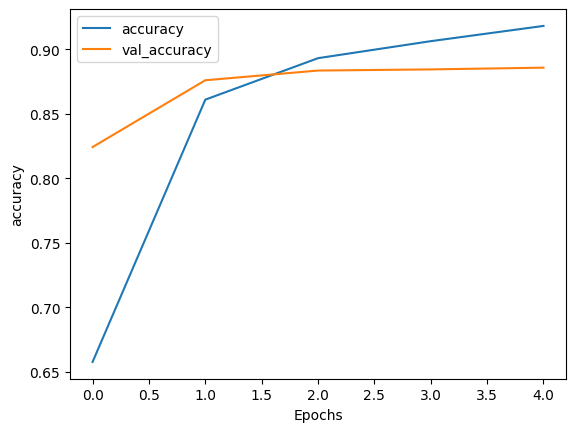

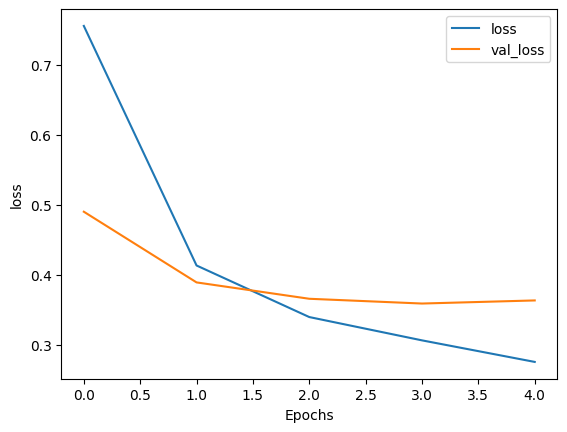

In [61]:
plot_graphs(history1, "accuracy")
plot_graphs(history1, "loss")

In [62]:
def userIn(mo):
    x=input("enter sentence or x for exit: ")
    while x != "x":
        predict_user_input([x] , mo)
        x=input("enter sentence or x for exit: ")
        
userIn(model1)

enter sentence or x for exit:  good morning


1/1 [==============================] - 0s 130ms/step
         Tweets   labels
0  good morning  neutral


enter sentence or x for exit:  good results when i use this tool i like it and it helped me and better than google


1/1 [==============================] - 0s 21ms/step
                                              Tweets labels
0  good results when i use this tool i like it an...   good


enter sentence or x for exit:  worst result, I did not expect that unwanted results. it is a useless tool


1/1 [==============================] - 0s 22ms/step
                                              Tweets labels
0  worst result, I did not expect that unwanted r...    bad


enter sentence or x for exit:  x


# Lstm

In [63]:
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences

# Tokenize the input text
tokenizer = Tokenizer(num_words=7000)
tokenizer.fit_on_texts(data["tweets"])


# Pad the sequences to a fixed length
max_len = 140

# word embeding

In [95]:
import numpy as np
from keras.utils import to_categorical

# Load pre-trained word embeddings
embedding_dim = 100
embeddings_index = {}
with open('/kaggle/input/glove6b100dtxt/glove.6B.100d.txt', encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

# Create an embedding matrix for the tokenizer
word_index = tokenizer.word_index
#num_words = min(len(word_index), 7000)
num_words =  7000
embedding_matrix = np.zeros((num_words, embedding_dim))
for word, i in word_index.items():
    if i >= num_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# Convert the output labels to one-hot encoded vectors
y_train_en = to_categorical(y_train)
y_test_en = to_categorical(y_test)

# training model

In [102]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense
from keras.callbacks import EarlyStopping

# Create the model
model2 = Sequential()
model2.add(Embedding(num_words, embedding_dim, input_length=max_len, weights=[embedding_matrix], trainable=True))
model2.add(LSTM(64, dropout=0.3, recurrent_dropout=0.3))
model2.add(Dense(3, activation='softmax'))
#model2.add(Dense(3, activation='relu'))


# Compile the model
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
#model2.fit(X_train, y_train_onehot, validation_data=(X_test, y_test_onehot), epochs=10, batch_size=1024)
history2 = model2.fit(X_train, y_train_en, epochs=10, batch_size=1024, validation_split=0.1, callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.001)])

Epoch 1/10
118/118 [==============================] - 103s 847ms/step - loss: 0.9515 - accuracy: 0.5284 - val_loss: 0.7528 - val_accuracy: 0.6667
Epoch 2/10
118/118 [==============================] - 99s 843ms/step - loss: 0.6715 - accuracy: 0.7105 - val_loss: 0.5223 - val_accuracy: 0.8004
Epoch 3/10
118/118 [==============================] - 96s 810ms/step - loss: 0.5107 - accuracy: 0.8011 - val_loss: 0.4421 - val_accuracy: 0.8374
Epoch 4/10
118/118 [==============================] - 91s 774ms/step - loss: 0.4374 - accuracy: 0.8377 - val_loss: 0.3985 - val_accuracy: 0.8573
Epoch 5/10
118/118 [==============================] - 89s 759ms/step - loss: 0.3925 - accuracy: 0.8577 - val_loss: 0.3746 - val_accuracy: 0.8712
Epoch 6/10
118/118 [==============================] - 89s 755ms/step - loss: 0.3624 - accuracy: 0.8717 - val_loss: 0.3495 - val_accuracy: 0.8819
Epoch 7/10
118/118 [==============================] - 89s 758ms/step - loss: 0.3427 - accuracy: 0.8826 - val_loss: 0.3416 - val_a

# testing

In [103]:
def get_measurements(true_y, pred_y, average='micro'):
    return {
      "accuracy": accuracy_score(true_y, pred_y),
      "recall": recall_score(true_y, pred_y, average=average),
      "precision": precision_score(true_y, pred_y, average=average),
      "fscore": f1_score(true_y, pred_y, average=average),
  }

predicted_labels = model2.predict(X_test, verbose=1)
get_measurements(y_test,  np.argmax(predicted_labels, axis=1))

1048/1048 [==============================] - 46s 43ms/step


{'accuracy': 0.8922425363118495,
 'recall': 0.8922425363118495,
 'precision': 0.8922425363118495,
 'fscore': 0.8922425363118495}

In [104]:


print(predict_user_input([
    'chatgpt is very crazy !', 
    'chatgpt is kind a dangerous', 
    'woooow, chatgt is really impressive !!!',
    "chatgpt is an AI tool",
    "good results"] , model2))

print("")

print(predict_user_input([
    "The worst result, I did not expect that unwanted results. it is a useless tool",
    "my name is ahmed i want to became a data scientist",
    'woooow, chatgpt is really impressive i can not imagine how chatgpt generate solution like humans  ',
    "chatgpt is an AI helpful tool to help solve complex problems and take less time than traditional way i like it",
    "good results when i use this tool i like it and it helped me and better than google"
] , model2) )

print("finished")

1/1 [==============================] - 0s 57ms/step
                                    Tweets   labels
0                  chatgpt is very crazy !      bad
1              chatgpt is kind a dangerous  neutral
2  woooow, chatgt is really impressive !!!      bad
3                    chatgpt is an AI tool  neutral
4                             good results      bad
(array([[0.96926314, 0.00313953, 0.02759743],
       [0.05117762, 0.01485317, 0.9339692 ],
       [0.9639692 , 0.00390977, 0.03212115],
       [0.01277558, 0.00637683, 0.9808476 ],
       [0.9752965 , 0.00693896, 0.01776448]], dtype=float32),                                     Tweets   labels
0                  chatgpt is very crazy !      bad
1              chatgpt is kind a dangerous  neutral
2  woooow, chatgt is really impressive !!!      bad
3                    chatgpt is an AI tool  neutral
4                             good results      bad)

1/1 [==============================] - 0s 55ms/step
                           

In [105]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()


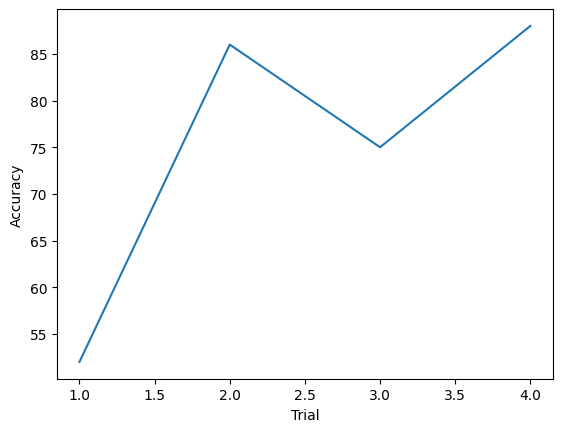

In [90]:
#x = [1 , 2 , 3 , 4]
x= np.array([1, 2 , 3 ,  4])
y = [52 , 86 , 75 , 88]
y= np.array([52 , 86 , 75 , 88])
#plt.plot(x)
plt.plot(x,y)

plt.xlabel("Trial")
plt.ylabel("Accuracy")
plt.show()

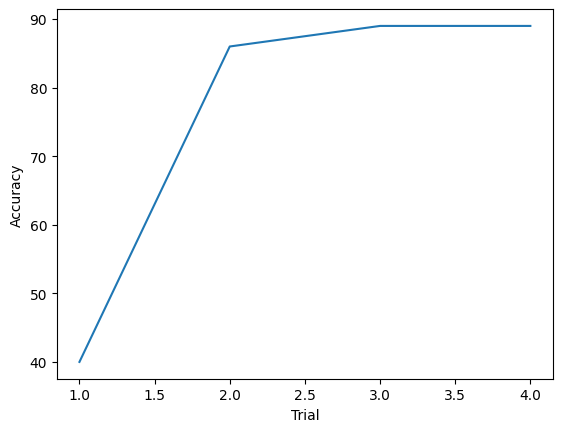

In [108]:
x = [1 , 2 , 3 , 4]
y = [40 ,  86  , 89, 89]
#plt.plot(x)
plt.plot(x,y)

plt.xlabel("Trial")
plt.ylabel("Accuracy")
plt.show()

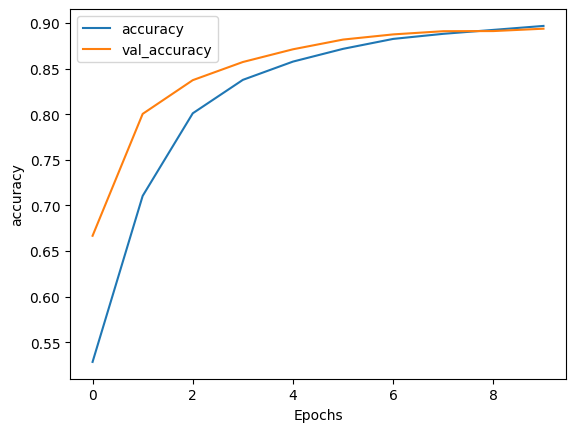

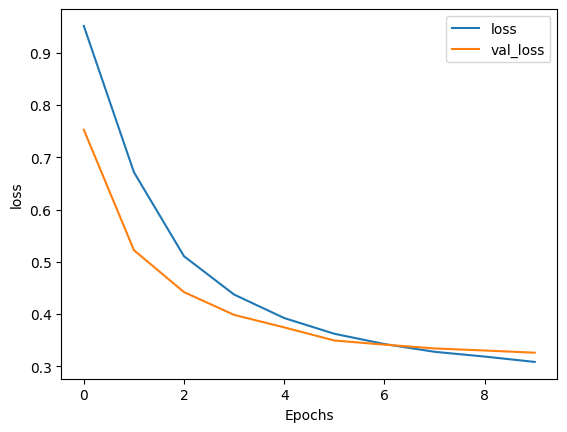

In [106]:
plot_graphs(history2, "accuracy")
plot_graphs(history2, "loss")

In [107]:
def userIn(model):
    x=input("enter sentence or x for exit: ")
    while x != "x":
        predict_user_input([x] , model)
        x=input("enter sentence or x for exit: ")
        
userIn(model2)
        

enter sentence or x for exit:  chatgpt is kind a dangerous


1/1 [==============================] - 0s 83ms/step
                        Tweets   labels
0  chatgpt is kind a dangerous  neutral


enter sentence or x for exit:  chatgpt is an AI helpful tool to help solve complex problems and take less time than traditional way i like it


1/1 [==============================] - 0s 61ms/step
                                              Tweets labels
0  chatgpt is an AI helpful tool to help solve co...   good


enter sentence or x for exit:  very bad


1/1 [==============================] - 0s 63ms/step
     Tweets labels
0  very bad    bad


enter sentence or x for exit:  x
